In [1]:
import pandas as pd

In [2]:
nflDF = pd.read_csv('data/nflplaybyplay2009to2017//nfl2009_2017.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nflDF = nflDF[nflDF.PlayType.isin(['Pass', 'Run'])]
playType = nflDF[['PlayType']]
playType.replace(['Pass', 'Run'],[1, 0], inplace=True)
playType.reset_index(inplace=True, drop=True)

homeTeamDummy = pd.get_dummies(nflDF.HomeTeam)
awayTeamDummy = pd.get_dummies(nflDF.AwayTeam)
qtrDummy = pd.get_dummies(nflDF.qtr)

modelDF0 = pd.concat([playType, homeTeamDummy, awayTeamDummy, qtrDummy, nflDF[['TimeSecs', 'yrdln', 'ydsnet']]], axis=1)
modelDF0 = modelDF0.dropna()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
modelDF0.shape
# (193128, 79)

(193128, 79)

In [5]:
modelDF0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193128 entries, 1 to 280182
Data columns (total 79 columns):
PlayType    193128 non-null float64
ARI         193128 non-null float64
ATL         193128 non-null float64
BAL         193128 non-null float64
BUF         193128 non-null float64
CAR         193128 non-null float64
CHI         193128 non-null float64
CIN         193128 non-null float64
CLE         193128 non-null float64
DAL         193128 non-null float64
DEN         193128 non-null float64
DET         193128 non-null float64
GB          193128 non-null float64
HOU         193128 non-null float64
IND         193128 non-null float64
JAC         193128 non-null float64
JAX         193128 non-null float64
KC          193128 non-null float64
LA          193128 non-null float64
LAC         193128 non-null float64
MIA         193128 non-null float64
MIN         193128 non-null float64
NE          193128 non-null float64
NO          193128 non-null float64
NYG         193128 non-nu

In [18]:
modelDF0

,PlayType,ARI,ATL,BAL,BUF,CAR,CHI,CIN,CLE,DAL,...,TEN,WAS,1,2,3,4,5,TimeSecs,yrdln,ydsnet
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3593.0,42.0,5.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3556.0,47.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3515.0,44.0,2.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3496.0,2.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3460.0,2.0,4.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3431.0,6.0,2.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3384.0,43.0,3.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3348.0,40.0,13.0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3321.0,30.0,12.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3283.0,31.0,21.0


In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
lr.score(X_test, y_test)

0.5684513022316574

In [21]:
probs = lr.predict_proba(X_test)

In [22]:
preds = probs[:, 1]

In [23]:
from sklearn.metrics import roc_curve, auc

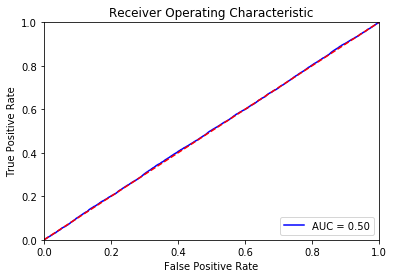

In [24]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test, lr.predict(X_test))

0.5

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, n_estimators=100)

In [27]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
clf.score(X_test, y_test)

0.5684513022316574

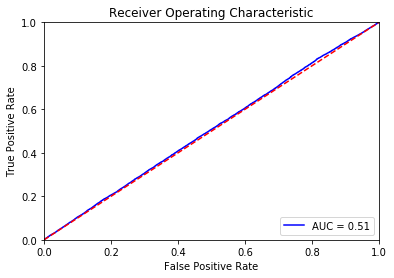

In [29]:
# calculate the fpr and tpr for all thresholds of the classification
predsRF = clf.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, predsRF)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()